# Sanity check for STDP visualizing
Les poids sont fixes et non plus normaux, pour faciliter la visualisation

## D'après le super papier de Froemke and Dan 2002 :
A+ = 103 %, A- = 51%

theta+ = 13.3 ms, theta- = 34.5ms

# 1/ Visualiser les poids du ring après son apprentissage

In [1]:
simtime = 2000
threads = 1

In [2]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [1]:

def tuning_function(x, j, B, fmax): #von mises
    N = len(x)
    if B==np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True,
            seq_nbr= None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    #extracts the spiketrains
    
    #fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array
    N = len(spike_array)

    #mod = GaussianModel()
    from lmfit import Model, Parameters
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360), 
                  ('fmax', y.max(), True,  0.0, 200.))
    
    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws, show_init=False)
    
    #eye cancer-triggering lines
    sigma = out.best_values['B']

    
    if do_title :
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f'%sigma)
    
    return ax, sigma
    

def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype = float)
        
        spiketrain_cut = np.where((spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]
        
        spiketrain_len.append(len(spiketrain_cut))
    
    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [4]:
def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        
        axs4 = plt.subplot(gs[0:1 , 4:6])
        axs5 = plt.subplot(gs[0:1 , 6:8])
        axs6 = plt.subplot(gs[1:2 , 4:6])
        axs7 = plt.subplot(gs[1:2 , 6:8])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(cut_spiketrain(SpikesP, 0), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 0) , axs4, seq_nbr = 1)[1]
        axs4.set_xticklabels([])
        axs4.set_yticklabels([])
        axs4.set_xlabel('')
        axs4.set_ylabel('')
        
        axs5.plot(cut_spiketrain(SpikesP, 1), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 1) , axs5, seq_nbr = 2)[1]
        axs5.set_xticklabels([])
        axs5.set_yticklabels([])
        axs5.set_xlabel('')
        axs5.set_ylabel('')
        
        axs6.plot(cut_spiketrain(SpikesP, 2), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 2) , axs6, seq_nbr = 3)[1]
        axs6.set_xticklabels([])
        axs6.set_yticklabels([])
        axs6.set_xlabel('')
        axs6.set_ylabel('')
        
        axs7.plot(cut_spiketrain(SpikesP, 3), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 3) , axs7, seq_nbr = 4)[1]
        axs7.set_xlabel('Neuron index')
        axs7.set_ylabel('Sequence spikes', rotation = 270)
        axs7.yaxis.tick_right()
        axs7.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig

# Simulation

In [5]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

rng = sim.NumpyRNG(seed=42)

rate_gain = 20.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 15  # degrees
sparseness = .9

In [6]:
weight_inp_exc, weight_inp_inh = .5, .1
weight_exc_inh = .025
delay_exc_inh = rnd('normal_clipped', mu=1., sigma=9.5, low=0.1, high=15, rng=rng)
weight_exc_exc  = .015
weight_inh_inh, weight_inh_exc = .1, 0.00
A_scale, DA = .00000001, 1.5
#delay_exc_exc, delay_inh_inh, delay_exc_inh, delay_inh_ex = 2., 3., 4., 4.
delay_inp_exc = 1.

delay_inh_exc, delay_inp_inh = 2.5, 2.5
#normal_weights = stdp_weight_init

In [7]:
def run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh):
    
    

    stdp_max_w = 100 * np.max((weight_exc_exc, weight_exc_inh))

    sim.setup(timestep=.1, threads=threads)
    exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Excitateurs")

    inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                         initial_values={"v": neuron_parameters["v_reset"]},
                         label="Neurones Inhibiteurs")

    input_pop = sim.Population(n_pop,
                               sim.SpikeSourcePoisson(duration=simtime, start=0),
                               label="Entree Orientation")

    def vary_angle(t):
        '''
        callback function that shifts the maximum angle
        '''

        n_pop = 60
        shift = 40
        noise = .33

        angle = 1. * np.arange(n_pop)
        rates = tuning_function(angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, rate_gain)
        rates = (1-noise)*rates + noise * rate_gain
        
        for i, cell in enumerate(input_pop):
            cell.set_parameters(rate=rates[i])

        return t + simtime/4
    
    #delays = rnd('normal_clipped', mu=3., sigma=1.5, low=0.1, high=5, rng=rng)
    causal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=DA*A_scale, A_minus=A_scale/DA)
    anticausal_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                          A_plus=-A_scale/DA, A_minus=-A_scale*DA)
    #sym_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
    #                                      A_plus=A_scale, A_minus=-1.2*A_scale)
    #antisym_hebbian_rule = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
    #                                      A_plus=-A_scale, A_minus=1.2*A_scale)


    causal_STDP_syn = sim.STDPMechanism(
        timing_dependence=causal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight=stdp_weight_init,
        weight=weight_exc_exc,
        delay=rnd('normal_clipped', mu=3., sigma=.05, low=0.1, high=5, rng=rng),
        #delay=rnd('normal_clipped', mu=.5, sigma=.25, low=0.1, high=5, rng=rng),
        #          delay="0.2 + 0.01*d",
        dendritic_delay_fraction=1.)

    anticausal_STDP_syn = sim.STDPMechanism(
        timing_dependence=anticausal_hebbian_rule,
        weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
        #weight_dependence=sim.MultiplicativeWeightDependence(w_min=0, w_max=stdp_max_w),
        weight=weight_exc_inh,
        delay=rnd('normal_clipped', mu=3., sigma=4.5, low=0.1, high=5, rng=rng),
        dendritic_delay_fraction=1.)
    

    # Input
    syn_inp_exc = sim.Projection(input_pop, exc,
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=causal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_exc, 
                                     delay=rnd('normal_clipped', mu=3., sigma=.05, low=0.1, high=5, rng=rng)
                                     ),
                                 receptor_type='excitatory')

    syn_inp_inh = sim.Projection(input_pop, inh,
                                 #connector=sim.FixedProbabilityConnector(
                                 #    sparseness, rng=rng),
                                 connector=sim.OneToOneConnector(),
                                 #synapse_type=anticausal_STDP_syn,
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inp_inh, 
                                     delay=rnd('normal_clipped', mu=3., sigma=.05, low=0.1, high=5, rng=rng)
                                     ),
                                 receptor_type='excitatory')
    # Intras-iso
    syn_exc_exc = sim.Projection(exc, exc,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 synapse_type=causal_STDP_syn,
                                 receptor_type='excitatory')
    
    syn_inh_inh = sim.Projection(inh, inh,
                                 #connector=sim.DistanceDependentProbabilityConnector("exp(-d/2.)"),
                                 #connector=sim.DistanceDependentProbabilityConnector("exp(-d**2/2/5)"),
                                 #connector=sim.IndexBasedProbabilityConnector("1-exp(-abs(i-j))"),
                                 connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                 synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_inh, 
                                     delay=rnd('normal_clipped', mu=3., sigma=1.5, low=0.1, high=5, rng=rng)
                                 ),
                                 receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

    # Intras-cross
    syn_exc_inh = sim.Projection(exc, inh,
                                 connector=sim.FixedProbabilityConnector(
                                     sparseness, rng=rng),
                                 #synapse_type=sim.StaticSynapse(
                                 #    weight=weight_exc_inh, delay=delay_exc_inh),
                                 synapse_type=anticausal_STDP_syn,
                                 receptor_type='excitatory')
    
    syn_inh_exc = sim.Projection(inh, exc,
                                #connector=sim.OneToOneConnector(),
                                connector=sim.FixedProbabilityConnector(sparseness, rng=rng),
                                synapse_type=sim.StaticSynapse(
                                     weight=weight_inh_exc, delay=delay_inh_exc),
                                receptor_type='inhibitory')

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, rate_gain)
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    exc.record('spikes')
    inh.record('spikes')
    input_pop.record('spikes')
    sim.run(simtime, callbacks=[vary_angle])
    
    sim.end()

    exc_data = exc.get_data().segments[0]
    inh_data = inh.get_data().segments[0]
    inp_data = input_pop.get_data().segments[0]

    fig = SuperPlotter(inp_data, exc_data, inh_data,
                 60, rates, simtime,
                 title= f'A_scale, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh={A_scale}, {weight_exc_exc}, {weight_exc_inh}, {weight_inh_exc}, {weight_inh_inh}',
                 figsize = (14,6)
                 )
    #fit_plot(n_pop, exc_data)

    sim.reset()
    plt.show()
    return fig
    #fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

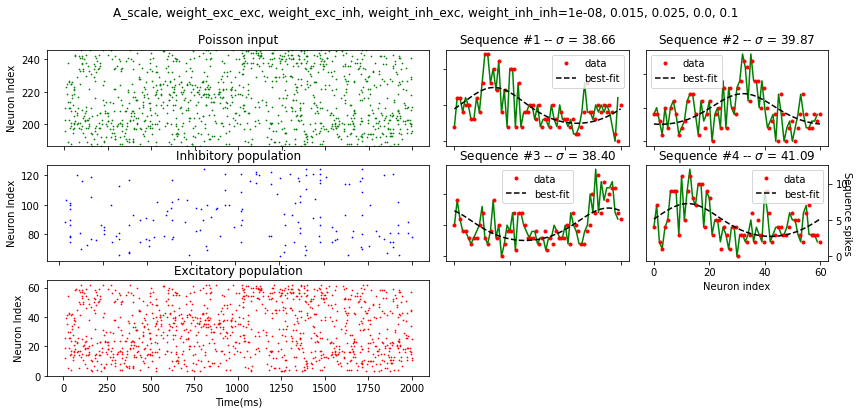

In [8]:
fig = run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh)

In [9]:
N_scan = 5

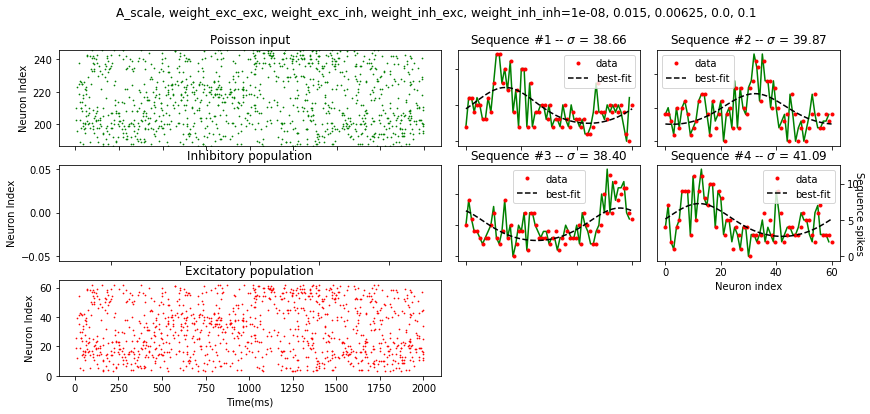

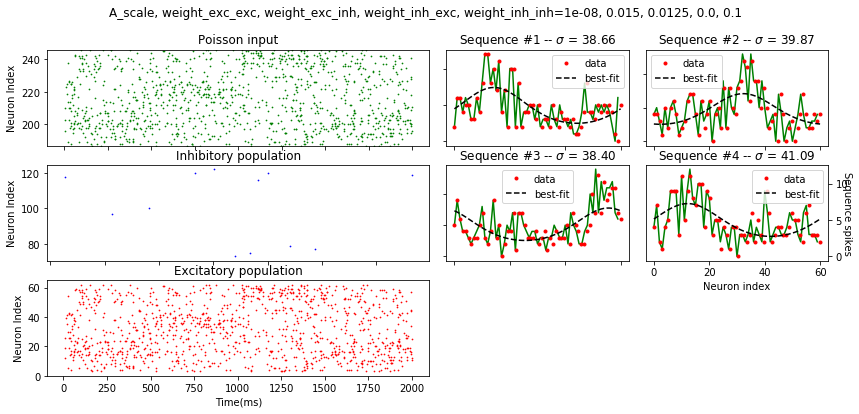

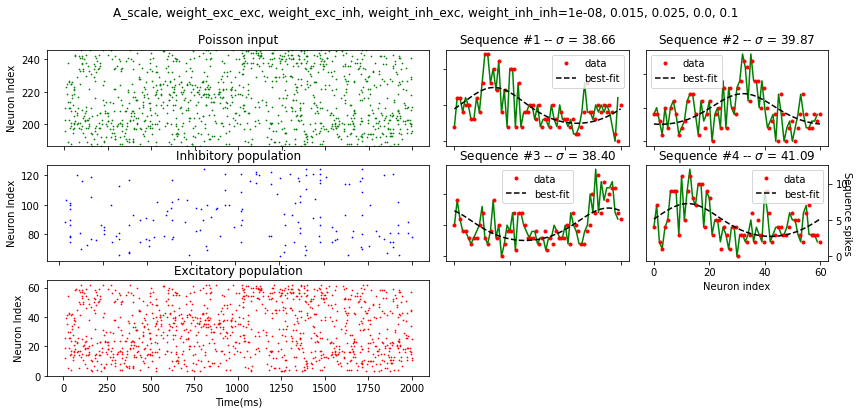

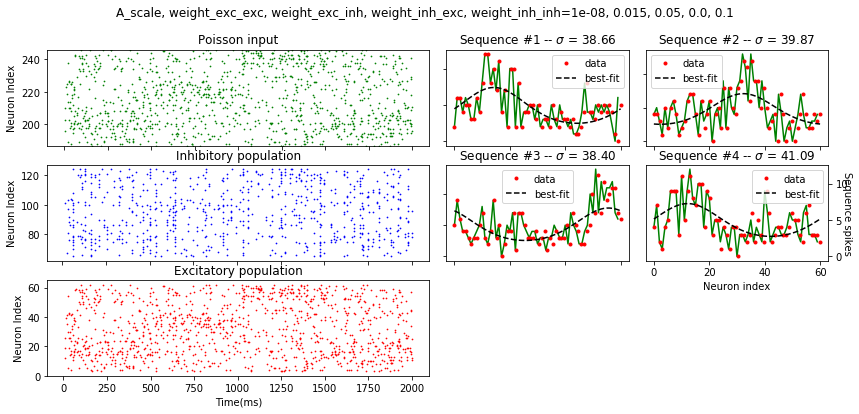

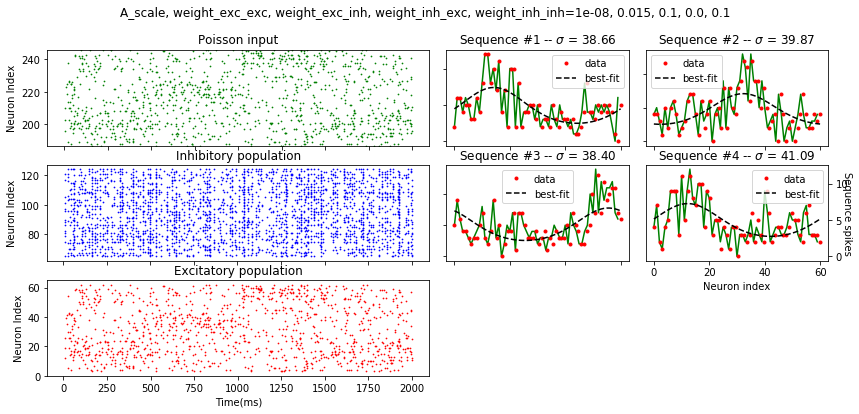

In [10]:
for weight_exc_inh_ in weight_exc_inh*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh_, weight_inh_exc, weight_inh_inh)
    plt.show()

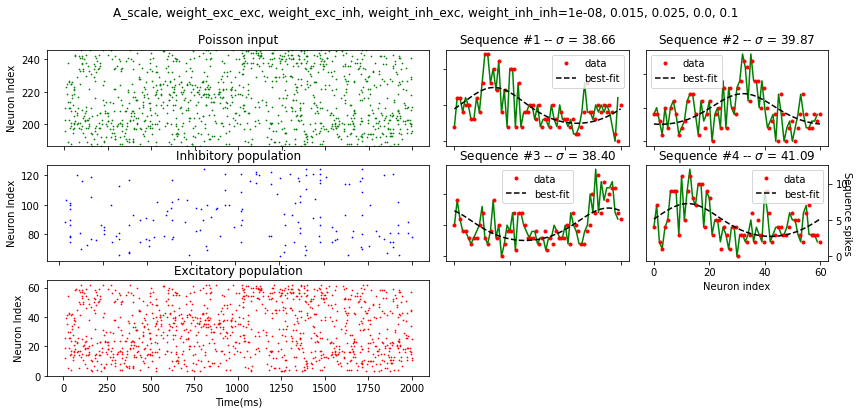

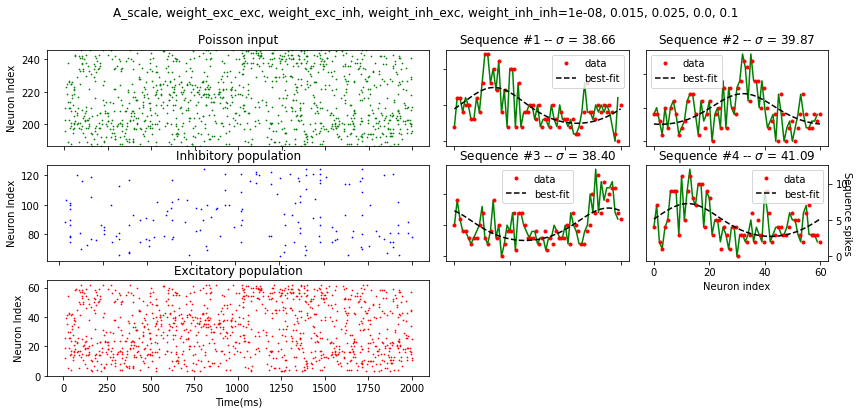

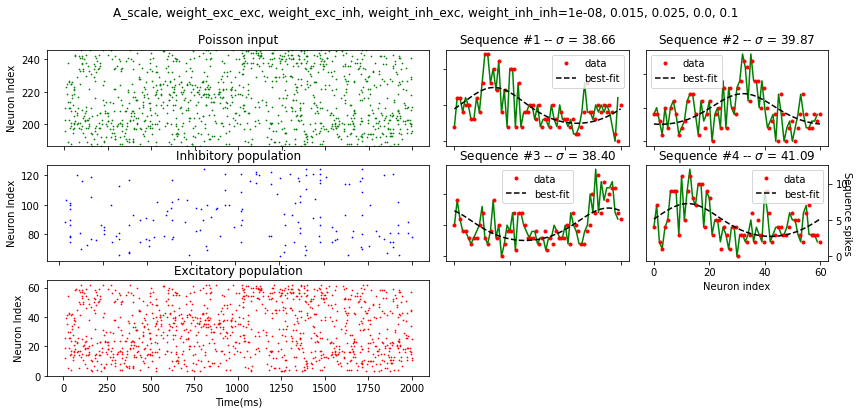

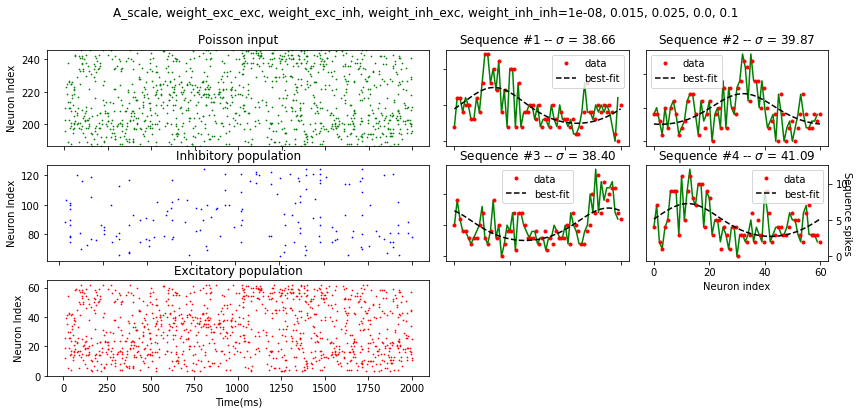

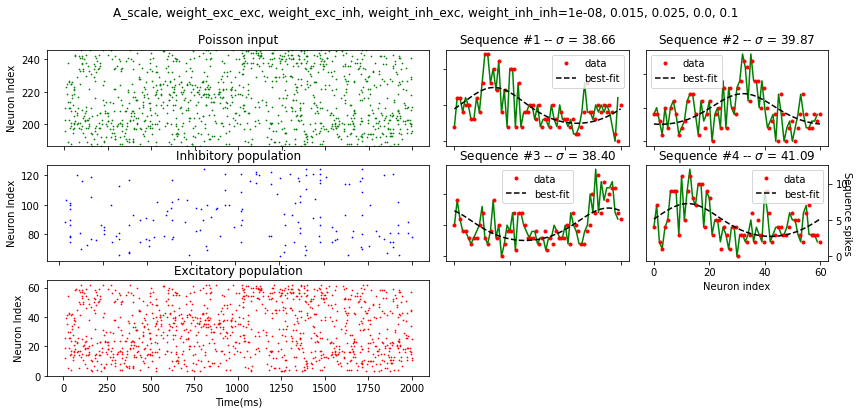

In [11]:
for weight_exc_exc_ in weight_exc_exc*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh)
    plt.show()

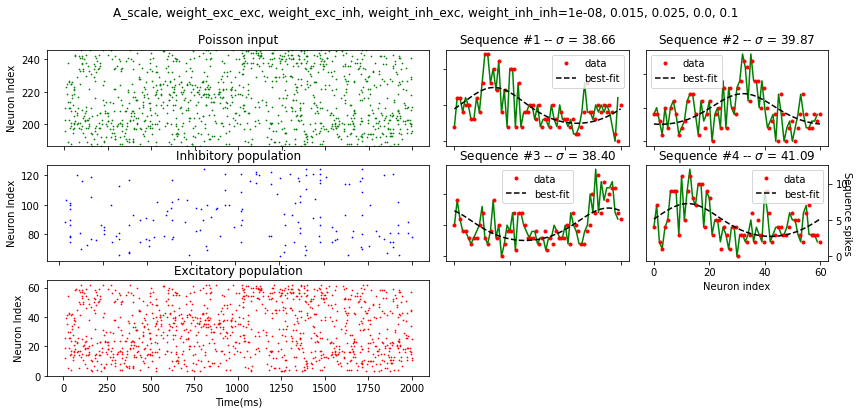

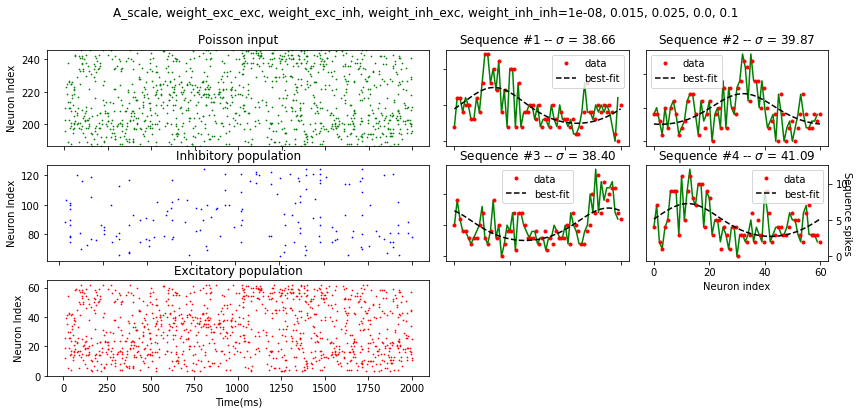

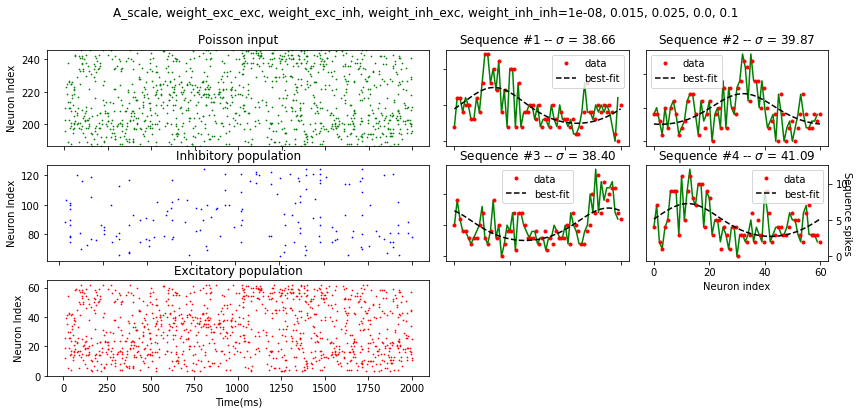

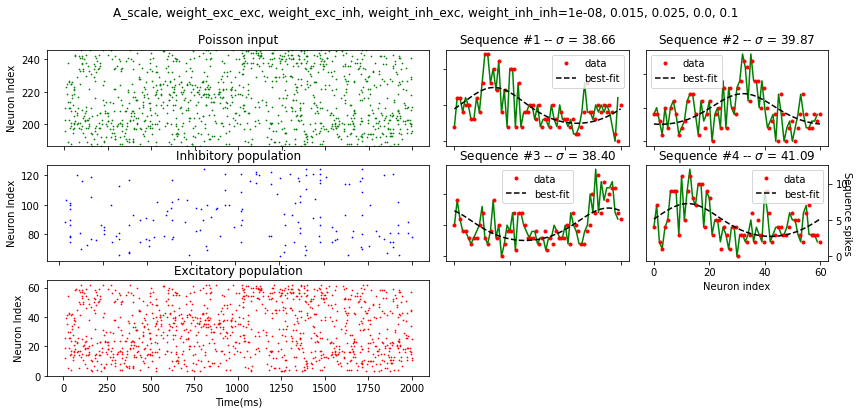

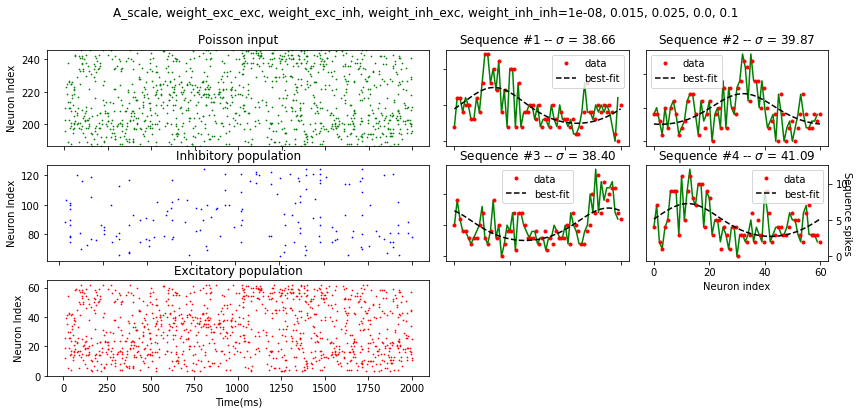

In [12]:
for weight_inh_exc_ in weight_inh_exc*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc_, weight_inh_inh)
    plt.show()

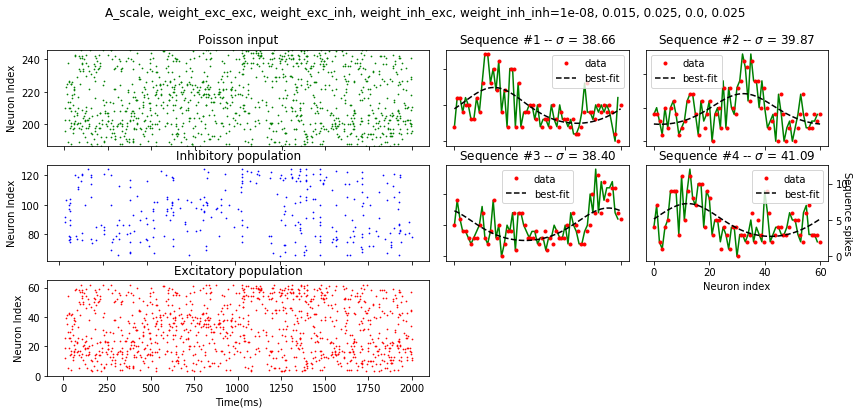

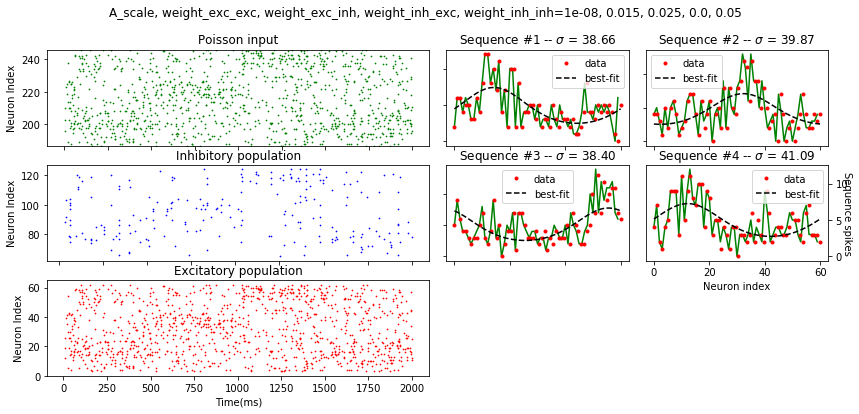

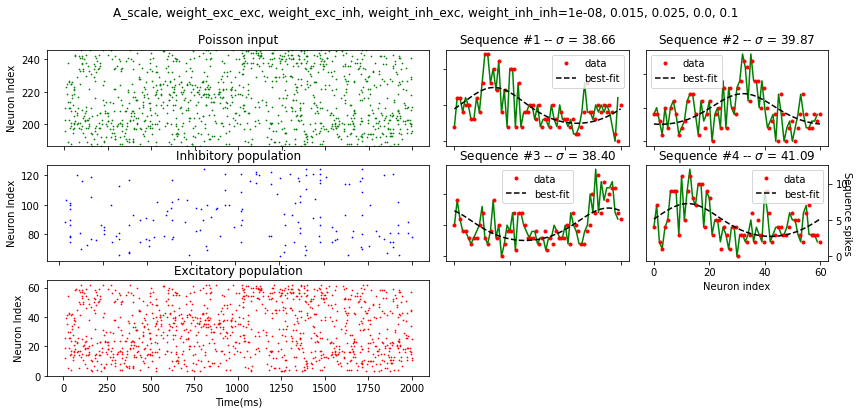

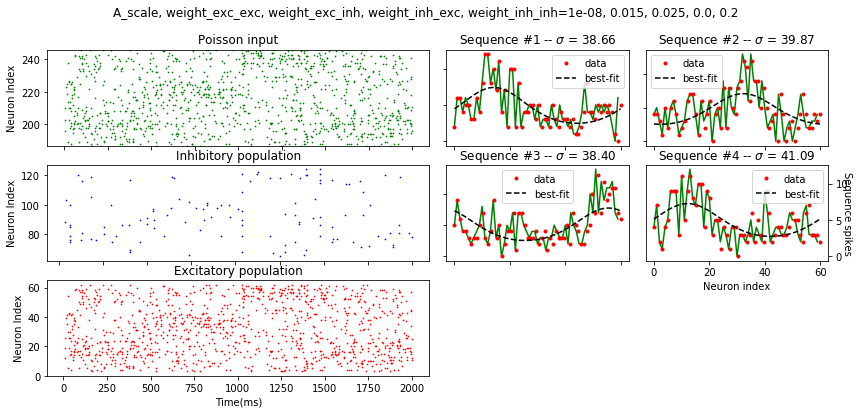

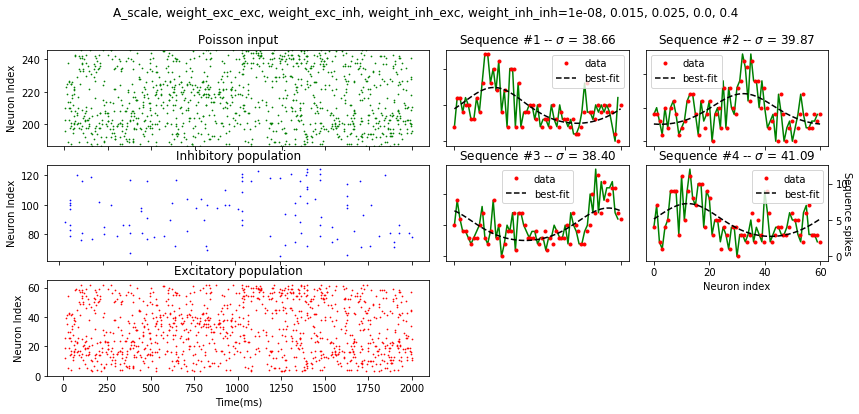

In [13]:
for weight_inh_inh_ in weight_inh_inh*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh_)
    plt.show()

## learning

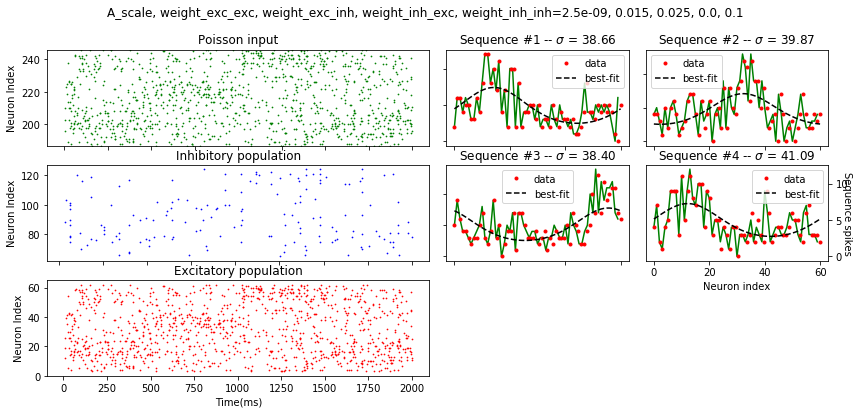

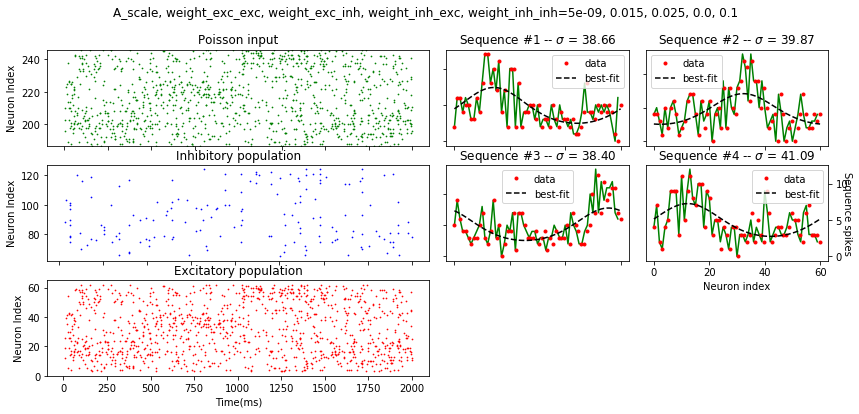

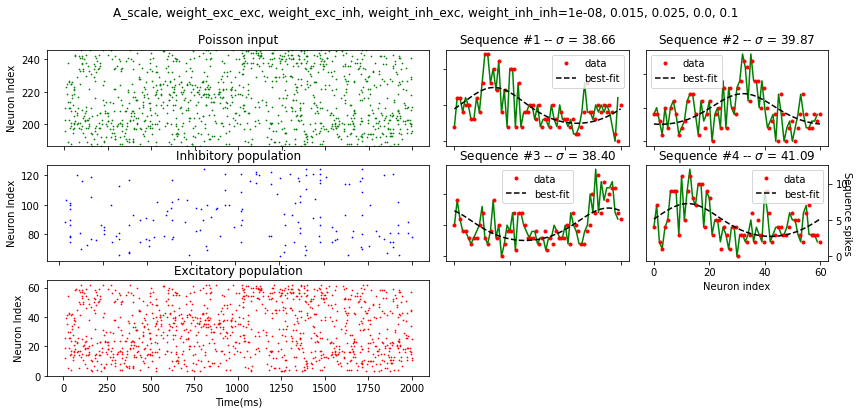

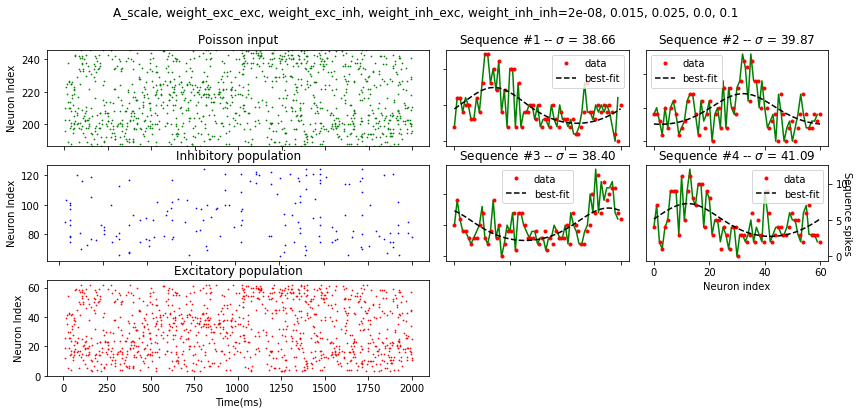

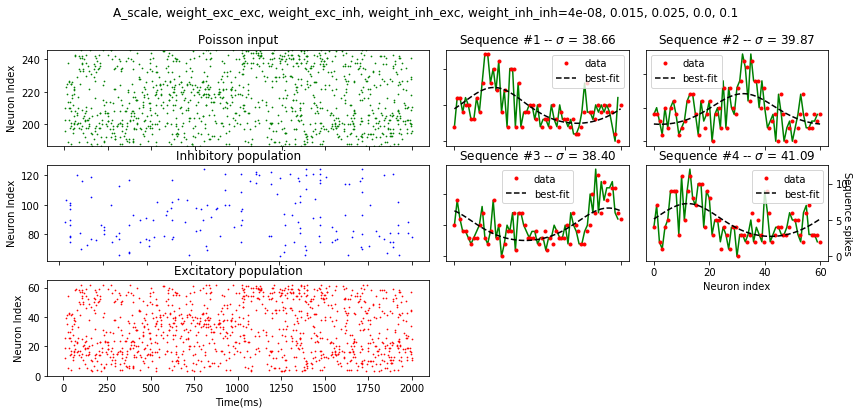

In [14]:
for A_scale_ in A_scale*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale_, DA, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh)
    plt.show()

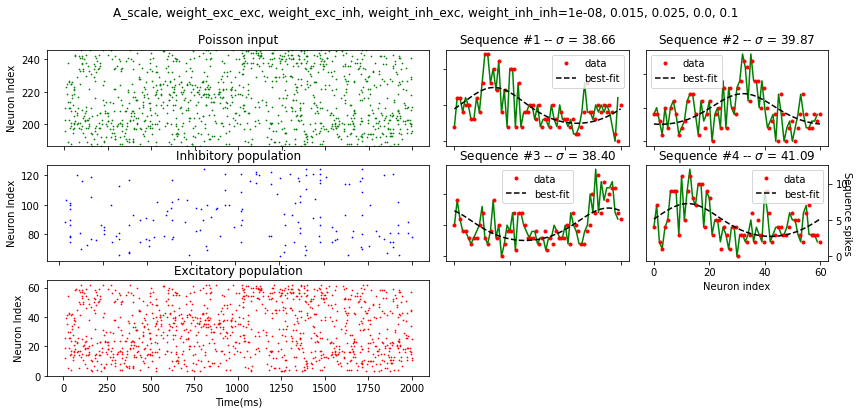

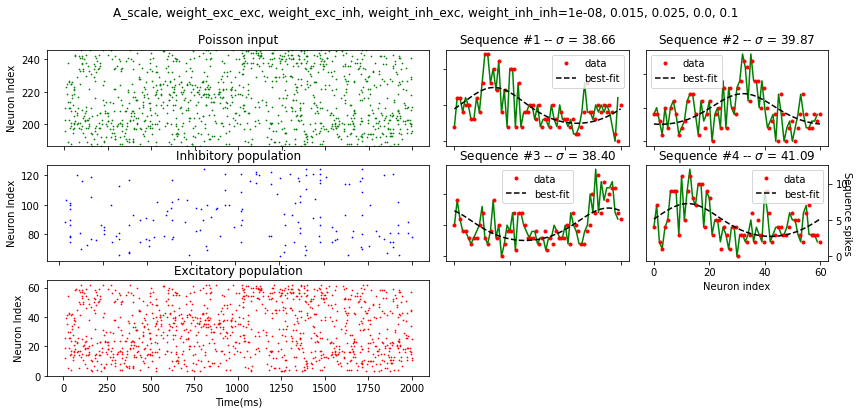

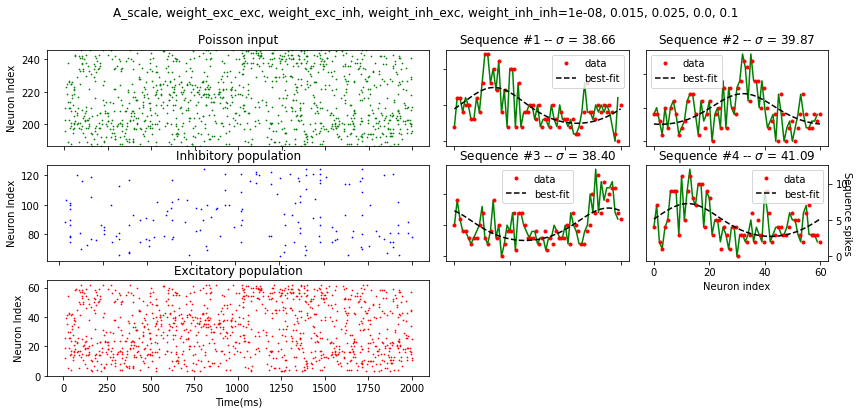

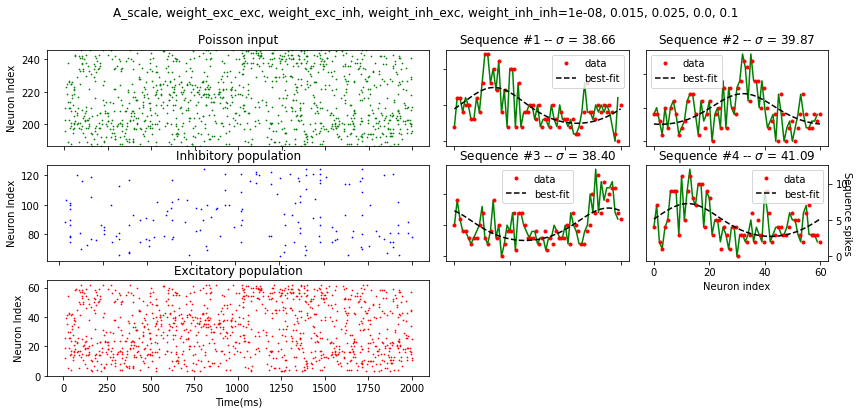

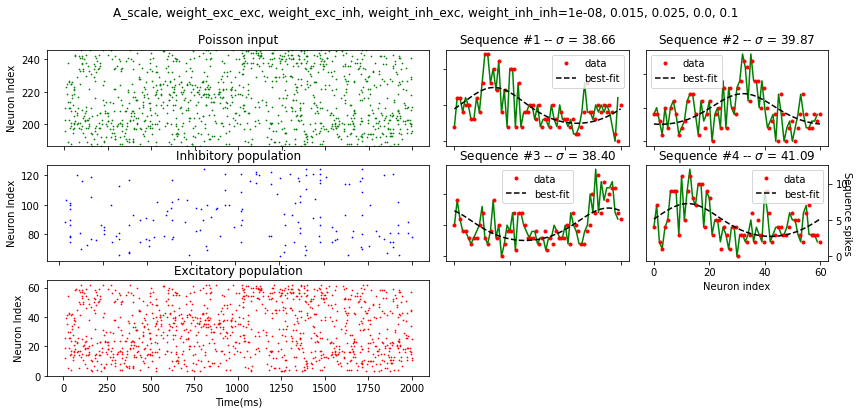

In [15]:
for DA_ in DA*np.logspace(-1, 1, N_scan, base=4):
    fig = run_simu(A_scale, DA_, weight_exc_exc, weight_exc_inh, weight_inh_exc, weight_inh_inh)
    plt.show()